# <font color = #FF0000>**Model Preparation**</font>

## <font color = #0e46a1>**Data Acquisition**</font>

#### <font color = #696969>**Import Libraries**</font>

In [1]:
import numpy   as np
import pandas  as pd

In [2]:
import json

#### <font color = #696969>**Import Data**</font>

In [3]:
with open('Sample Data.json', 'r') as f:
    SData_json = json.load(f)
SData = pd.read_json(SData_json)

In [4]:
XData = SData.copy().drop(['is_fraud'], axis = 1)

In [5]:
YData = SData['is_fraud'].copy()

## <font color = #0e46a1>**Split into Training and Test Sets**</font>

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
XTrain, XTest, YTrain, YTest = train_test_split(XData, YData, test_size = 0.3, random_state = 2023, stratify = YData)

## <font color = #0e46a1>**Create k-Fold Cross-Validation Sets**</font>

In [8]:
from sklearn.model_selection import StratifiedKFold

In [9]:
KFold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2023)

#### <font color = #696969>**Train the model**</font>

In [10]:
from sklearn.svm import SVC

In [11]:
def SVM():
    
    SV = SVC(random_state = 2023, kernel = 'rbf', tol = 0.01, probability = True, degree = 3, gamma = 'scale')
    
    return SV

In [12]:
Classifier = SVM()

In [13]:
from sklearn.metrics         import log_loss
from sklearn.model_selection import cross_val_predict

In [14]:
def Cross_Validation(XTrain, YTrain, KFold, Classifier):
    
    TrainingScores = []
    CrossValScores = []
    
    Prediction = pd.DataFrame(data = [], index = YTrain.index, columns = [0,1])
    
    for train_index, cv_index in KFold.split(np.zeros(len(XTrain)), YTrain.ravel()):
    
        XTrain_Fold, YTrain_Fold = XTrain.iloc[train_index,:], YTrain.iloc[train_index]
        XCross_Fold, YCross_Fold = XTrain.iloc[cv_index,:],    YTrain.iloc[cv_index]
     
        Classifier.fit(XTrain_Fold, YTrain_Fold)
        
        Prediction.loc[XCross_Fold.index,:] = Classifier.predict_proba(XCross_Fold)

        loglossTraining = log_loss(YTrain_Fold, Classifier.predict_proba(XTrain_Fold)[:,1])
        loglossCV       = log_loss(YCross_Fold, Prediction.loc[XCross_Fold.index,1])
        
        TrainingScores.append(loglossTraining)
        CrossValScores.append(loglossCV)
    
        print('  Training Log Loss: ', loglossTraining)
        print('        CV Log Loss: ', loglossCV)
        
    loglossClassifier = log_loss(YTrain, Prediction.loc[:,1])
    
    print('\nClassifier Log Loss: ', loglossClassifier)
    
    return Prediction

In [15]:
Prediction = Cross_Validation(XTrain, YTrain, KFold, Classifier)

  Training Log Loss:  0.20215031266235586
        CV Log Loss:  0.23264982614014693
  Training Log Loss:  0.202468134170952
        CV Log Loss:  0.25607610247771645
  Training Log Loss:  0.2030123179233697
        CV Log Loss:  0.2406751286324435
  Training Log Loss:  0.20381442547345663
        CV Log Loss:  0.22448594644238695
  Training Log Loss:  0.20215976638136737
        CV Log Loss:  0.23895054637022975
  Training Log Loss:  0.20143099942311515
        CV Log Loss:  0.2524899998751509
  Training Log Loss:  0.2019340919326555
        CV Log Loss:  0.26209565705690097
  Training Log Loss:  0.2029688277667686
        CV Log Loss:  0.24594378349353738
  Training Log Loss:  0.20150191140349
        CV Log Loss:  0.22749346921196956
  Training Log Loss:  0.2026161759927951
        CV Log Loss:  0.25015168481065425

Classifier Log Loss:  0.2431020288092103


## <font color = #0e46a1>**Model Performance**</font>

#### <font color = #696969>**Evaluate the model**</font>

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [17]:
def Scores(YTrain, Prediction):
    
    YPrediction = (Prediction >= 0.7837936354160855).astype(int)

    A = accuracy_score(YTrain, YPrediction)*100
    P = precision_score(YTrain, YPrediction)*100
    R = recall_score(YTrain, YPrediction)*100
    F = f1_score(YTrain, YPrediction)*100
    
    A_Porcent = "{:.2f}%".format(A)
    P_Porcent = "{:.2f}%".format(P)
    R_Porcent = "{:.2f}%".format(R)
    F_Porcent = "{:.2f}%".format(F)
    
    print(' Accuracy: ',A_Porcent)
    print('Precision: ',P_Porcent)
    print('   Recall: ',R_Porcent)
    print('       F1: ',F_Porcent)

In [18]:
S = Scores(YTrain, Prediction.loc[:,1])

 Accuracy:  90.40%
Precision:  97.47%
   Recall:  82.95%
       F1:  89.62%


#### <font color = #696969>**Confusion Matrix**</font>

In [19]:
import matplotlib.pyplot as plt

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
import seaborn as sns

In [22]:
YPrediction = (Prediction.loc[:,1] >= 0.7837936354160855).astype(int)

In [23]:
CM = confusion_matrix(YTrain, YPrediction)

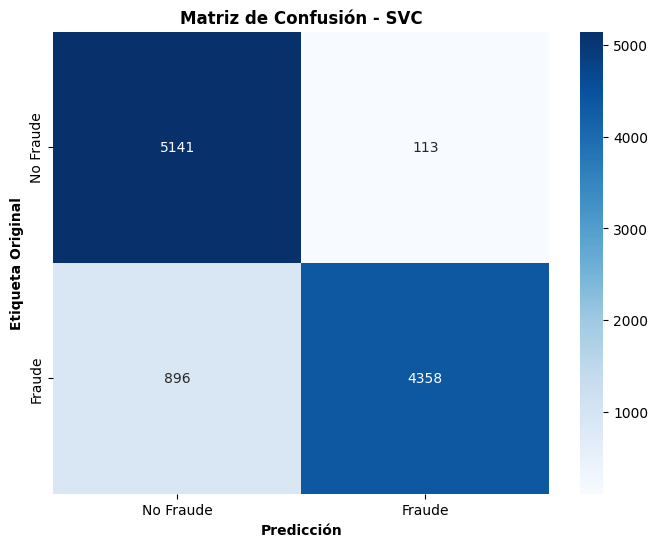

In [24]:
labels = ['No Fraude','Fraude']

plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot = True, fmt="d", cmap = "Blues", xticklabels = labels, yticklabels = labels)

plt.xticks(fontweight='light')
plt.yticks(fontweight='light')

plt.xlabel('Predicción', fontweight='bold')
plt.ylabel('Etiqueta Original', fontweight='bold')

plt.title('Matriz de Confusión - SVC', fontweight = 'bold')

plt.savefig('Heatmap - SVC - Entrenamiento.png')

plt.show()

#### <font color = #696969>**Precision-Recall Curve**</font>

In [25]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

In [26]:
def Curves(YTrain, AnomalyScores, returnPredictions = False):

    Predictions = pd.concat([YTrain, AnomalyScores], axis = 1)
    Predictions.columns = ['True', 'Prediction: AnomalyScores']

    Precision, Recall, Thresholds = precision_recall_curve(Predictions['True'], Predictions['Prediction: AnomalyScores'])

    Average_Precision = average_precision_score(Predictions['True'],Predictions['Prediction: AnomalyScores'])

    plt.step(Recall, Precision, color = 'blue', alpha = 0.7, where = 'post')

    plt.fill_between(Recall, Precision, step = 'post', alpha = 0.3, color = 'blue')

    plt.xlabel('Sensibilidad ')
    plt.ylabel('Precisión ')

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Curva de Precisión-Sensibilidad: Precisión Promedio = {0:0.2f}'.format(Average_Precision), fontweight = 'bold')
    
    plt.savefig('ROC - SVC - Entrenamiento.png')

    plt.show()

    fpr, tpr, thresholds = roc_curve(Predictions['True'], Predictions['Prediction: AnomalyScores'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color = 'blue', lw = 2, label = 'Curva ROC')
    plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('Proporción Falsos Positivos')
    plt.ylabel('Proporción Verdaderos Positivos')

    #plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC), fontweight = 'bold')
    plt.title('Área bajo la Curva = {0:0.2f}'.format(areaUnderROC), fontweight = 'bold')
    plt.legend(loc = "lower right")
    
    plt.savefig('AUC - SVC - Entrenamiento.png')
    
    plt.show()

    if returnPredictions == True:
        return Predictions

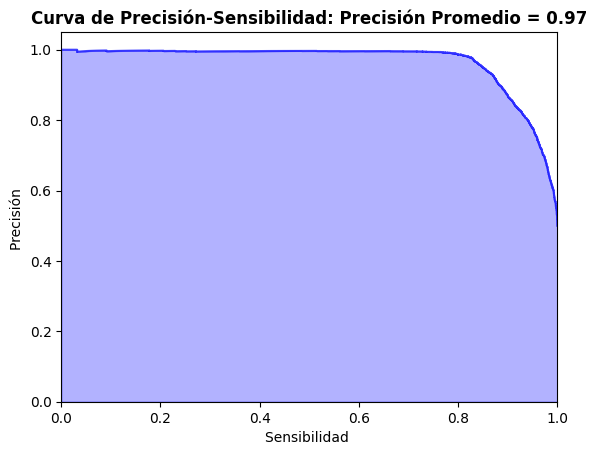

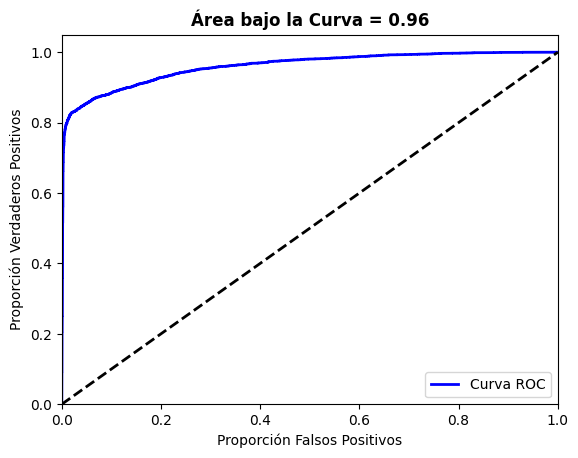

In [27]:
Curves = Curves(YTrain, Prediction.loc[:,1],True)

#### <font color = #696969>**Test the model**</font>

In [28]:
def Performance(XTest, YTest, Classifier):
    
    Predictions = pd.DataFrame(data = [],index = YTest.index, columns = ['prediction'])
    
    Predictions[Predictions.columns[0]] = Classifier.predict_proba(XTest)[:, 1]
    
    loglossClassifier = log_loss(YTest, Predictions)
    
    print('Classifier Log Loss: ', loglossClassifier)
    
    return Predictions

In [29]:
Predictions = Performance(XTest, YTest, Classifier)

Classifier Log Loss:  0.2501844881985181


In [30]:
def Score(YTrain, Prediction):
    
    YPrediction = (Prediction >= 0.7837936354160855).astype(int)

    A = accuracy_score(YTrain, YPrediction)*100
    P = precision_score(YTrain, YPrediction)*100
    R = recall_score(YTrain, YPrediction)*100
    F = f1_score(YTrain, YPrediction)*100
    
    A_Porcent = "{:.2f}%".format(A)
    P_Porcent = "{:.2f}%".format(P)
    R_Porcent = "{:.2f}%".format(R)
    F_Porcent = "{:.2f}%".format(F)
    
    print(' Accuracy: ',A_Porcent)
    print('Precision: ',P_Porcent)
    print('   Recall: ',R_Porcent)
    print('       F1: ',F_Porcent)

In [31]:
Scores = Score(YTest, Predictions)

 Accuracy:  90.41%
Precision:  97.30%
   Recall:  83.13%
       F1:  89.66%


In [32]:
YPrediction = (Predictions >= 0.7837936354160855).astype(int)

In [33]:
CM = confusion_matrix(YTest, YPrediction)

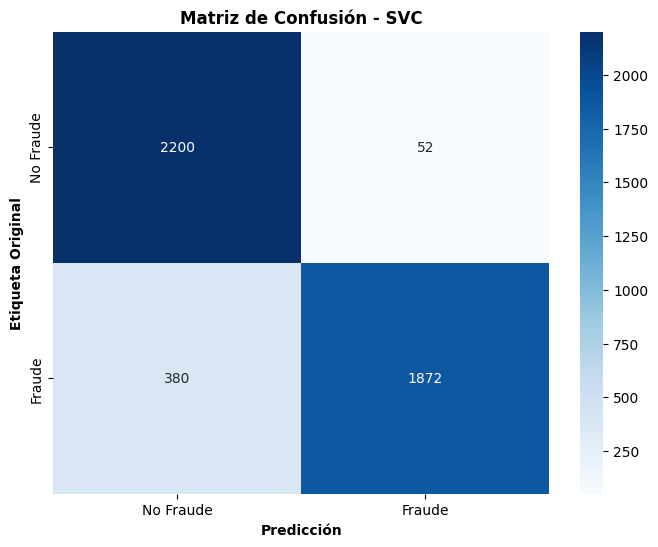

In [34]:
labels = ['No Fraude','Fraude']

plt.figure(figsize = (8, 6))
sns.heatmap(CM, annot = True, fmt="d", cmap = "Blues", xticklabels = labels, yticklabels = labels)

plt.xticks(fontweight ='light')
plt.yticks(fontweight ='light')

plt.xlabel('Predicción', fontweight = 'bold')
plt.ylabel('Etiqueta Original', fontweight = 'bold')

plt.title('Matriz de Confusión - SVC', fontweight = 'bold')

plt.savefig('Heatmap - SVC - Prueba.png')

plt.show()

In [35]:
def Curve(YTrain, AnomalyScores, returnPredictions = False):

    Predictions = pd.concat([YTrain, AnomalyScores], axis = 1)
    Predictions.columns = ['True', 'Prediction: AnomalyScores']

    Precision, Recall, Thresholds = precision_recall_curve(Predictions['True'], Predictions['Prediction: AnomalyScores'])

    Average_Precision = average_precision_score(Predictions['True'],Predictions['Prediction: AnomalyScores'])

    plt.step(Recall, Precision, color = 'blue', alpha = 0.7, where = 'post')

    plt.fill_between(Recall, Precision, step = 'post', alpha = 0.3, color = 'blue')

    plt.xlabel('Sensibilidad ')
    plt.ylabel('Precisión ')

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Curva de Precisión-Sensibilidad: Precisión Promedio = {0:0.2f}'.format(Average_Precision), fontweight = 'bold')
    
    plt.savefig('ROC - SVC - Prueba.png')

    plt.show()

    fpr, tpr, thresholds = roc_curve(Predictions['True'], Predictions['Prediction: AnomalyScores'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color = 'blue', lw = 2, label = 'Curva ROC')
    plt.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('Proporción Falsos Positivos')
    plt.ylabel('Proporción Verdaderos Positivos')

    #plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC), fontweight = 'bold')
    plt.title('Área bajo la Curva = {0:0.2f}'.format(areaUnderROC), fontweight = 'bold')
    plt.legend(loc = "lower right")
    
    plt.savefig('AUC - SVC - Prueba.png')
    
    plt.show()

    if returnPredictions == True:
        return Predictions

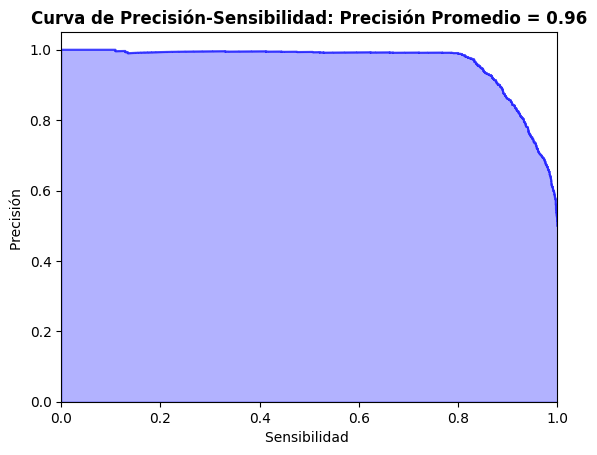

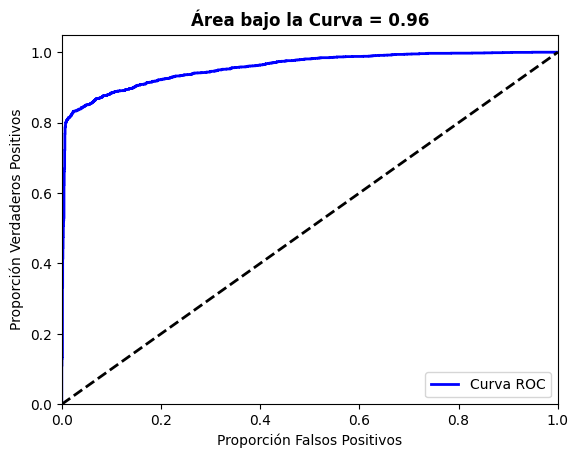

In [36]:
Curves = Curve(YTest, Predictions, True)

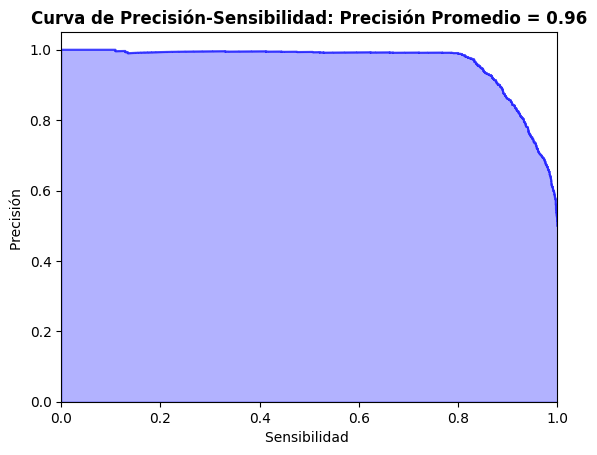

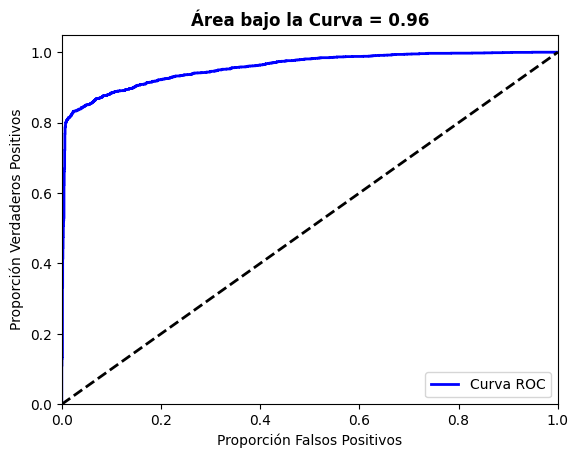

In [37]:
Curves = Curve(YTest, Predictions,True)